In [12]:
%load_ext autoreload
%autoreload 2

from dataset_prepare import *
from utils import custom_RFC
import pickle

from matplotlib import pyplot as plt

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets.standard_dataset import StandardDataset
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.metrics import ClassificationMetric
from sklearn.metrics import classification_report
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from IPython.display import Markdown, display

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from tqdm import tqdm
import imblearn

from dataset_prepare import prepare_standard_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = 12345679 

In [14]:
df = load_dataset()
df

,Num_Acc,trajet,catr,circ,nbv,prof,plan,surf,infra,situ,...,atm,col,catv,obs,obsm,choc,mortal,pieton,sexe_conducteur,age
0,202200000001,5,4,2,2,1,1,1,0,1,...,1,3,2,0,2,1,0,0,1,14
1,202200000001,5,4,2,2,1,1,1,0,1,...,1,3,2,0,2,1,0,0,1,74
2,202200000002,0,4,2,2,1,1,1,0,1,...,1,3,3,0,2,8,0,0,1,34
3,202200000002,4,4,2,2,1,1,1,0,1,...,1,3,3,0,2,8,0,0,1,52
4,202200000003,0,3,-1,2,1,1,1,5,1,...,1,2,3,0,2,1,0,0,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126656,202200055300,5,3,2,2,1,2,7,0,3,...,9,6,3,1,0,1,1,0,1,27
126657,202200055301,5,3,2,2,1,1,1,0,1,...,1,3,3,0,0,8,0,0,0,20
126659,202200055301,5,3,2,2,1,1,1,0,1,...,1,3,3,0,0,8,0,0,0,69
126660,202200055302,1,3,3,4,1,1,1,0,1,...,1,2,5,0,2,1,0,0,1,30


In [15]:
# valeurs catégorielles
categorical_features = ['trajet', 'catr', 'circ', 'nbv', 'prof',
                        'plan', 'surf', 'vma', 'lum', 'agg', 
                        'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton',
                        'sexe_conducteur', 'infra', 'situ']
# valeurs numériques
numerical_features = ['dep','age', 'mois']

print("numerical : ", numerical_features)
print("categorical : ", categorical_features)

numerical :  ['dep', 'age', 'mois']
categorical :  ['trajet', 'catr', 'circ', 'nbv', 'prof', 'plan', 'surf', 'vma', 'lum', 'agg', 'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton', 'sexe_conducteur', 'infra', 'situ']


In [16]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [17]:
label = 'mortal'

# Récupération des ensembles de train/test
X_train, X_test, y_train, y_test = test_train_sets(df)
df = df.drop(columns='Num_Acc')

In [19]:
dataset_orig_train, dataset_orig_valid, dataset_orig_test = prepare_standard_dataset(X_train, y_train, X_test, y_test, label, vt=True)

In [20]:
from utils import custom_RFC
import imblearn

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = custom_RFC(random_state=42)
lmod.fit(X_train, y_train)


fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(dataset_orig_valid.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(dataset_orig_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

In [21]:
unprivileged_groups=[{'sexe_conducteur': 0}]
privileged_groups=[{'sexe_conducteur': 1}]

In [22]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
0.0028462298862770713
Difference in GFNR between unprivileged and privileged groups
-0.005613707115563284


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.0021366226554851014
Difference in GFNR between unprivileged and privileged groups
-0.010199954033555447


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
0.001899839525464922
Difference in GFNR between unprivileged and privileged groups
0.0034995921952444276


In [23]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [24]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

In [25]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.005239076365792905
Difference in GFNR between unprivileged and privileged groups
0.00403674132938725


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.0013609467169549277
Difference in GFNR between unprivileged and privileged groups
0.013075046103977694


In [26]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
        dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:01<00:00, 13.91it/s]


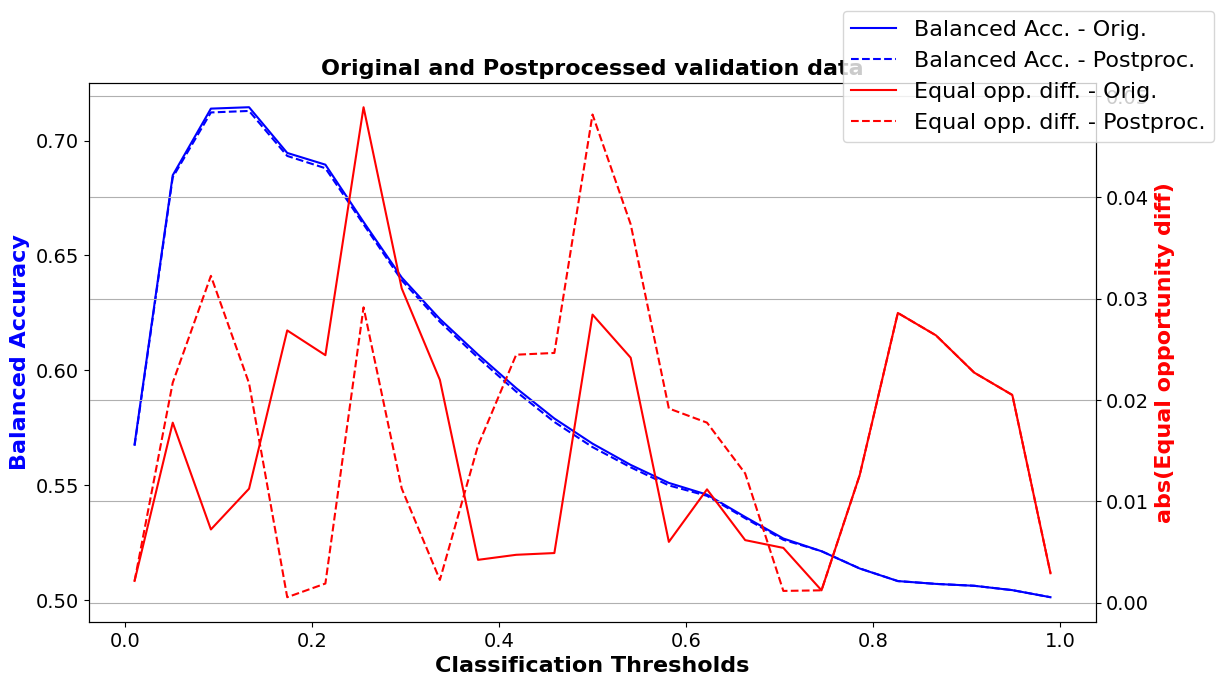

In [27]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

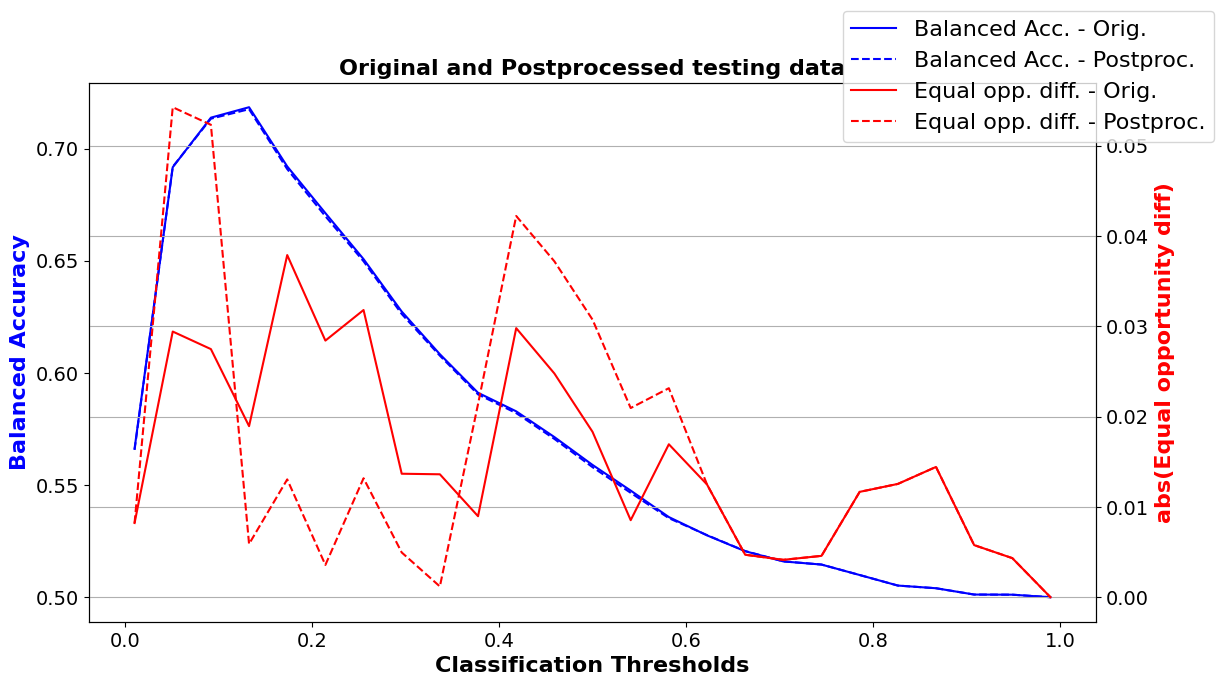

In [28]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)